In [21]:
import numpy as np
from sklearn.mixture import GaussianMixture
import matplotlib.pyplot as plt
from numpy.linalg import eigh
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt


In [9]:
# Training data: 3D trajectories
trajectories = []
for offset in [(0,0,0), (0.2,0.1,0.1), (-0.1, -0.2, 0.05)]:
    t = np.linspace(0, 1, 20)
    x = np.sin(2 * np.pi * t) + offset[0]
    y = np.cos(2 * np.pi * t) + offset[1]
    z = t + offset[2]
    traj = np.stack([t, x, y, z], axis=1)
    trajectories.append(traj)
    
# stack trajectories into a single array
data = np.vstack(trajectories)


In [10]:
gmm = GaussianMixture(n_components=5, covariance_type='full')
gmm.fit(data)

GaussianMixture(n_components=5)

In [34]:

def plot_cov_ellipse(ax, mean, cov, color='blue', alpha=0.2):
    from numpy.linalg import eigh
    vals, vecs = eigh(cov)
    u = np.linspace(0, 2 * np.pi, 20)
    v = np.linspace(0, np.pi, 20)
    x = np.outer(np.cos(u), np.sin(v))
    y = np.outer(np.sin(u), np.sin(v))
    z = np.outer(np.ones_like(u), np.cos(v))
    sphere = np.stack([x, y, z], axis=-1)
    for i in range(x.shape[0]):
        for j in range(x.shape[1]):
            pt = sphere[i, j]
            sphere[i, j] = vecs @ (np.sqrt(vals) * pt) + mean
    ax.plot_surface(sphere[:,:,0], sphere[:,:,1], sphere[:,:,2],
                    rstride=1, cstride=1, color=color, alpha=alpha)


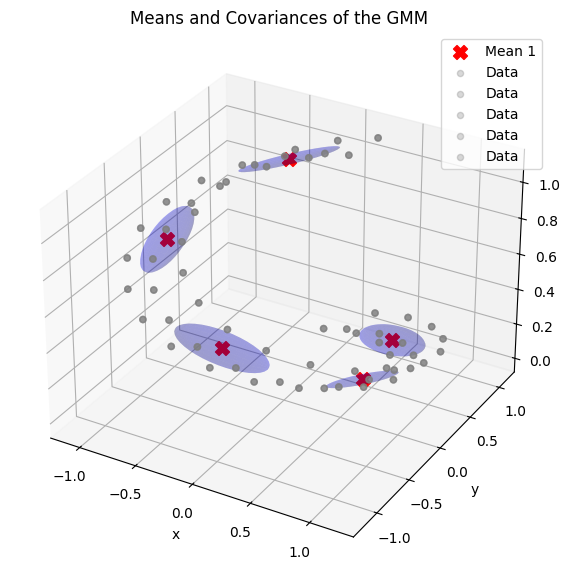

In [35]:
fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')

for i in range(gmm.n_components):
    mu_xyz = gmm.means_[i][1:4]
    cov_xyz = gmm.covariances_[i][1:4,1:4]
    plot_cov_ellipse(ax, mu_xyz, cov_xyz)
    ax.scatter(mu_xyz[0], mu_xyz[1], mu_xyz[2], color='red', s=100, marker='X', label=f'Mean {i+1}' if i == 0 else "")
    ax.scatter(data[:,1], data[:,2], data[:,3], c='gray', alpha=0.3, label='Data')

ax.set_xlabel("x")
ax.set_ylabel("y")
ax.set_zlabel("z")
ax.set_title("Means and Covariances of the GMM")
ax.legend()
plt.show()

## Gaussian Mixture Regression (GMR) with All Components

The model has multiple components, and to make realistic predictions we must:

### Do this for each $t$:

1. Compute the prediction $(x, y, z)$ of each component using:

$$
\mu_{x|t}^{(k)} = \mu_x^{(k)} + \Sigma_{xt}^{(k)} \left(\Sigma_{tt}^{(k)}\right)^{-1} (t - \mu_t^{(k)})
$$

2. Compute the **probability of that $t$ under each Gaussian**  
   → this is called **responsibility**.

3. Combine all the weighted predictions:

$$
\mu_{x|t} = \sum_k h_k(t) \cdot \mu_{x|t}^{(k)}
$$

where $h_k(t)$ is the "weight" or responsibility of component $k$ given $t$.


In [22]:
t_values = np.linspace(0, 1, 100)

def gmr_predict(gmm, t_values, in_idx=0, out_idx=[1, 2, 3]):
    n_components = gmm.n_components
    means = gmm.means_
    covs = gmm.covariances_
    weights = gmm.weights_
    preds=[]

    for t in t_values:
        mus = []
        probs = []
        for k in range (n_components):
            mu = means[k]
            cov = covs[k]
            mu_in = mu[in_idx]
            mu_out= mu[out_idx]

            Sigma_ii = cov[in_idx, in_idx]              # sigma tt
            Sigma_oi = cov[out_idx, in_idx]             # sigma xy

            correction = Sigma_oi * (1.0 / Sigma_ii) * (t - mu_in)
            mu_cond = mu_out + correction
            mus.append(mu_cond)

            p = (1.0 / np.sqrt(2 * np.pi * Sigma_ii)) * np.exp(-0.5 * ((t - mu_in) ** 2) / Sigma_ii)
            probs.append(weights[k] * p)

        probs = np.array(probs)
        probs = probs / np.sum(probs)
        mus = np.array(mus)
        pred = np.sum(probs[:, None] * mus, axis=0)
        preds.append(pred)

    return np.array(preds)



In [23]:
predicted_xyz = gmr_predict(gmm, t_values)
#print(predicted_xyz)

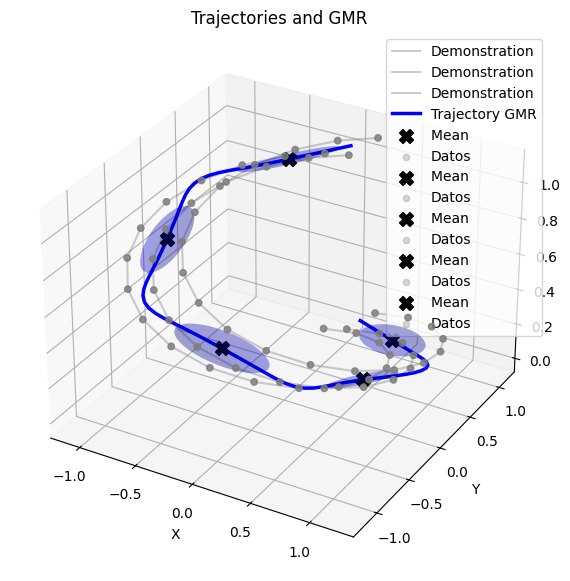

In [33]:


fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')

# Plot original trajectories 
for traj in trajectories:
    ax.plot(traj[:, 1], traj[:, 2], traj[:, 3], color='gray', alpha=0.4, label='Demonstration')

# Plot trajectory predicted by GMR
ax.plot(predicted_xyz[:, 0], predicted_xyz[:, 1], predicted_xyz[:, 2],
        color='blue', linewidth=2.5, label='Trajectory GMR')



for i in range(gmm.n_components):
    mu_xyz = gmm.means_[i][1:4]
    cov_xyz = gmm.covariances_[i][1:4,1:4]
    plot_cov_ellipse(ax, mu_xyz, cov_xyz)
    ax.scatter(mu_xyz[0], mu_xyz[1], mu_xyz[2], color='black', s=100, marker='X', label=f'Mean ')
    ax.scatter(data[:,1], data[:,2], data[:,3], c='gray', alpha=0.3, label='Datos')
    
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
ax.set_title("Trajectories and GMR")
ax.legend()
plt.show()